
# LIGHTGBM

-LIGHT GBM : 적은 학습시간과 메모리 사용량으로 각광받는 부스팅 알고리즘.

-리프 중심 트리 분할방식 -> 손실값을 가지는 리프노드를 지속적으로 분할

-원 핫 인코딩등을 사용하지않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행.

-파이썬 패키지명 'lightgbm' : 분류를 위한 LGBMclassifer 및 회귀를 위한 LGBMRegressor 클래스

-래퍼 클래스(Wrapper class)란, 다른 클래스나 모듈 등을 감싸서 사용하기 쉽게 만들어주는 클래스를 말합니다.

In [2]:
conda install -c conda -forge lightgbm


Note: you may need to restart the kernel to use updated packages.


usage: conda-script.py install [-h] [--revision REVISION]
                               [-n ENVIRONMENT | -p PATH] [-c CHANNEL]
                               [--use-local] [--override-channels]
                               [--repodata-fn REPODATA_FNS]
                               [--experimental {jlap,lock}]
                               [--strict-channel-priority]
                               [--no-channel-priority]
                               [--no-deps | --only-deps] [--no-pin] [--copy]
                               [--no-shortcuts] [-C] [-k] [--offline] [-d]
                               [--json] [-q] [-v] [-y] [--download-only]
                               [--show-channel-urls] [--file FILE]
                               [--solver {classic} | --experimental-solver {classic}]
                               [--force-reinstall]
                               [--freeze-installed | --update-deps | -S | --update-all | --update-specs]
                               [-m] 

LightGBM적용 -위스콘신 유방암 예측

In [32]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

In [33]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset=load_breast_cancer()
cancer_df=pd.DataFrame(data=dataset.data,columns=dataset.feature_names)

In [34]:
cancer_df['target']=dataset.target
X_features = cancer_df.iloc[:,:-1] ##데이터 셋의 마지막 열을 제외한 모든 열을 선택해 X_features에 할당
y_label = cancer_df.iloc[:,-1] ##데이터 셋의 마지막 열만 선택해 X_features에 할당

#전체 데이터중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)

In [35]:
#위에서 만든 x_train,y_train 을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=156) 

#앞서 xgboost와 동일하게 n_estimators 는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400,learning_rate=0.05)

#앞서 XGBoost와 동일하게 조기 중단 수행 가능.
evals=[(X_tr,y_tr),(X_val,y_val)]
lgbm_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric="logloss",
                eval_set=evals,verbose=True) ##50번 개선되지않으면 중단/ eval_metric : 검증데이터 성능 평가 -> "logloss" (손실)방식 사용

preds=lgbm_wrapper.predict(X_test) #lgbm_wrapper의 예측값.
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]#양성클래스 예측확률


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

# Lightgbm 기반 예측성능 평가

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [37]:
get_clf_eval(y_test,preds,pred_proba) 

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


#높은 정확도 보임.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

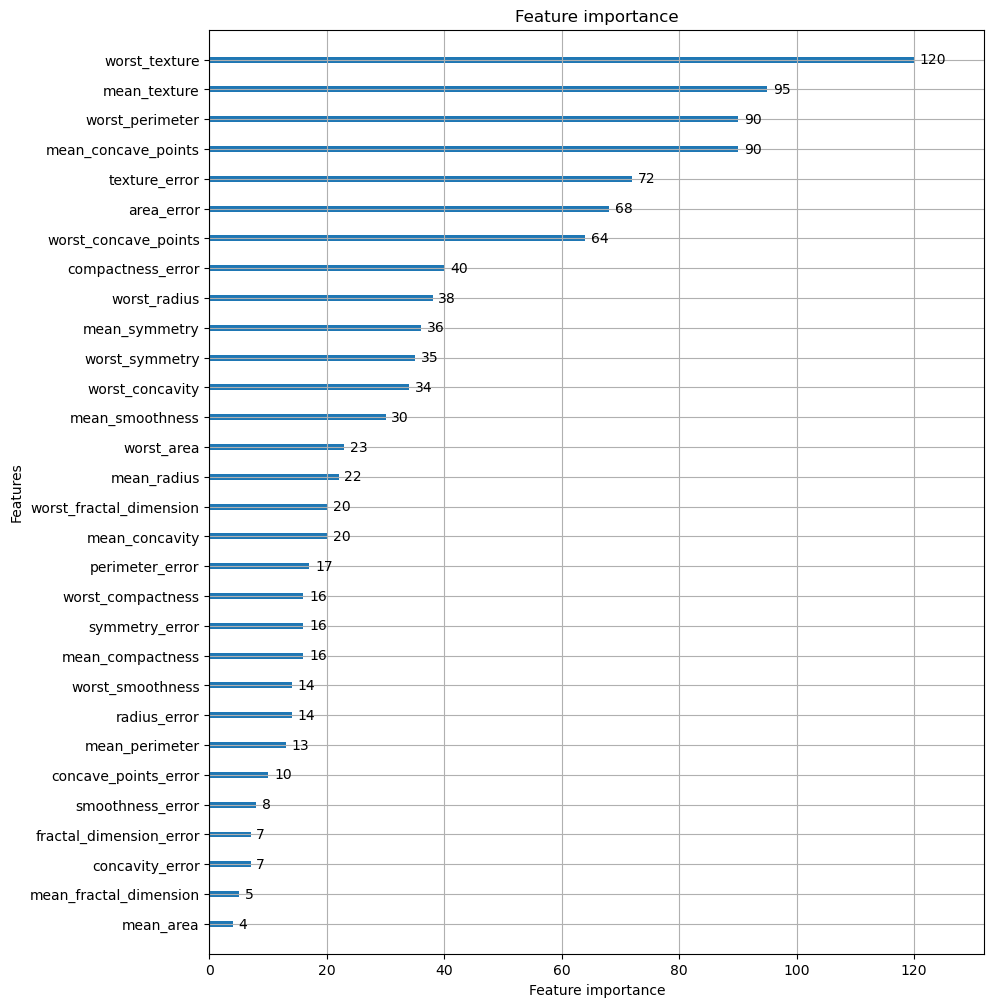

In [38]:
#plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance #피처 중요도를 시각화 하는 내장 API

import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)

#판단시 worst_texture,mean_texture등이 중요한 지표로 사용됨.

# 베이지안 최적화 기법의 HYPEROpt를 이용한 하이퍼 파라미터 튜닝

GridSearch 방식 - > 하이퍼 파라미터 개수 튜닝을 지금까지 해왔는데 하이퍼파라미터 갯수가 많을 경우 시간이 오래걸림.

베이지안 최적화 개요

-목적 함수 식을 제대로 알 수 없는 상황에서 최대또는 최소 함수 반환값을 만드는 최적 입력값을 가능한 적은 시도로 빠르게 찾아주는 방식

<대체모델&획득함수 개념>

대체 모델 : 획득함수로부터 최적함수를 예측할 수 있는 입력값을 추천받고 이를 기반으로 최적함수 모델을 개선해나감.
    
획득함수 : 개선된 대체 모델을 기반으로 최적 입력값 계산

at 하이퍼파라미터튜닝에서의 사용..

입력값: 하이퍼 파라미터
    
즉 대체모델은 획득함수가 계산한 하이퍼파라미터(입력값)를 입력받아 점차 개선되며, 개선된 대체모델을 기반으로

획득함수는 더 정확한 하이퍼 파라미터를 계산함.

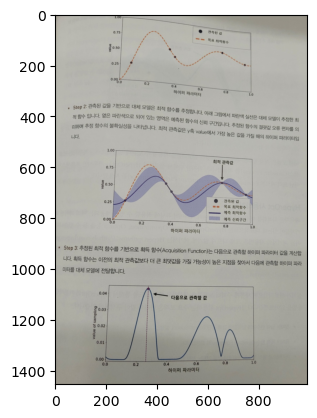

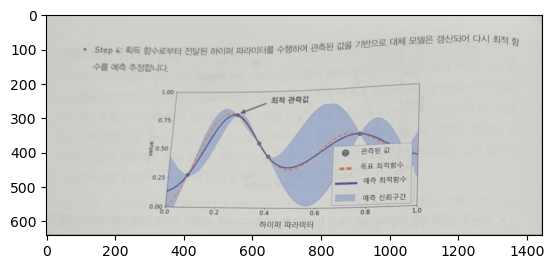

In [39]:

from matplotlib.image import imread

img = imread('사진캡처/hyperopt(1).JPG')  
plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()
img = imread('사진캡처/hyperopt(2).JPG')
plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

베이지안 최적화

step1) 랜덤하게 하이퍼파라미터를 샘플링하고 성능결과 관측, 그림(1)에서 검은 원은 특정 하이퍼파라미터가 입력되었을때 관측된 성능 지표
결과값을 뜻하며 주황색 사건이 찾아야 할 목표 최적함수임.

step2)관측된 값을 기반으로 대체 모델은 최적함수 추정.그림(2)에서 파란색 실선이 대체모델추정 최적함수 이고 옅은 파란색영역은 예측된 함수의 
신뢰구간임.추정된 함수의 결괏값오류 편차를 의미하며 불확실성을 나타냄. 최적관측값은 y축 value에서 가장 높은 값을 가질때의 하이퍼파라미터임.

step3) 추정된 최적함수를 기반으로 획득함수는 다음으로 관측할 하이퍼파라미터를 계산함.획득함수는 이전의 최적 관측값(y축 최대값)보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아 다음에 관측할 하이퍼파라미터를 대체 모델에 전달함.(그림3)

stpe4)획득함수로부터 전달된 하이퍼파라미터를 수행하여 관측된값을 기반으로 대체모델은 갱신되어 다시 최적함수를 예측(그림4)

# HyperOpt 사용하기

In [40]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


HyperOpt 주요 로직
1. 입력 변수명과 입력값의검색공간 설정
2.목적함수 설정.
3.목적함수의 반환 최솟값을 가지는 최적 입력값 유추

In [41]:
from hyperopt import hp

#입력값의 검색공간 설정하기

#-10~10까지 1간격을 가지는 입력변수(하이퍼파라미터) x와 -15~15까지 1간격으로 입력변수 y설정.
search_space={'x':hp.quniform('x',-10,10,10),'y':hp.quniform('y',-15,15,1)}

# hp.quniform(label,low,high,q) : label로 지정된 입력값 변수 검색 공간을 최솟값low에서 최댓값high 까지 q의 간격으로 설정
# hp.quniform(label,low,high) : 최솟값 low에서 최댓갑 ㅅhigh까지 정규 분포 형태의 검색 공간 설정

In [42]:
# 목적함수 생성하기
from hyperopt import STATUS_OK

#목적함수를 생성. 변숫값과 변수 검색 공간(search_space)을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x=search_space['x']
    y=search_space['y']
    retval = x**2-20*y
    
    return retval
    


In [43]:
#목적함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아준다. - > fmin()함수.

from hyperopt import fmin,tpe,Trials
#입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()


#목적함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도로(max_evals=5) 찾아냄.
best_01 = fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=5
              ,trials=trial_val,rstate=np.random.default_rng(seed=0))
print('best:',best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 830.39trial/s, best loss: -240.0]
best: {'x': -0.0, 'y': 12.0}


In [44]:
trial_val = Trials()


#max_evals을 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func,space=search_space,algo=tpe.suggest,max_evals=20
              ,trials=trial_val,rstate=np.random.default_rng(seed=0))
print('best:',best_02)

100%|██████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1000.02trial/s, best loss: -300.0]
best: {'x': 0.0, 'y': 15.0}


결과가 정확히 x=0 , y=15로 정답맞춤.

In [45]:
#fmin의 인자중 Trials 객체에는 results 속성과 vals 속성이 있음. 먼저 함수의 반복수행시마다 반환되는 반환값을 가지는 results를 보자.

#fmin()에 인자로 들어가는 Trials 객체의 rsult속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
#리스트 내부의 개별원소는 {'loss':함수 반환값,'status':반환 상태값}와 같은 딕셔너리임.
print(trial_val.results)
type(trial_val.results)


[{'loss': 0.0, 'status': 'ok'}, {'loss': -200.0, 'status': 'ok'}, {'loss': 40.0, 'status': 'ok'}, {'loss': -240.0, 'status': 'ok'}, {'loss': 80.0, 'status': 'ok'}, {'loss': -300.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 300.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 20.0, 'status': 'ok'}, {'loss': -100.0, 'status': 'ok'}, {'loss': 40.0, 'status': 'ok'}, {'loss': -60.0, 'status': 'ok'}, {'loss': 280.0, 'status': 'ok'}, {'loss': 160.0, 'status': 'ok'}, {'loss': -120.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


list

In [46]:
#Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨
print(trial_val.vals)

{'x': [-10.0, -0.0, 0.0, -0.0, 10.0, 0.0, 10.0, -10.0, -10.0, -0.0, -0.0, 0.0, 10.0, 10.0, 10.0, 0.0, -0.0, -0.0, 10.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [47]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-10.0,5.0,0.0
1,-0.0,10.0,-200.0
2,0.0,-2.0,40.0
3,-0.0,12.0,-240.0
4,10.0,1.0,80.0
5,0.0,15.0,-300.0
6,10.0,7.0,-40.0
7,-10.0,-10.0,300.0
8,-10.0,0.0,100.0
9,-0.0,-5.0,100.0


# HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

#적용할 하이퍼 파라미터와 검색공간 설정 -> 목적함수에서 Xgboost학습->예측성능 결과를 반환값으로 설정하고 fmin함수에서 목적함수를
하이퍼파라미터 검색공간의 입력값들을 사용하여 최적의 예측성능 결과를 반환하는 최적 입력값 결정

In [48]:
#전체 데이터 중 80%는 학습용,20%는 테스트용데이터 추출
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,test_size=0.2,random_state=156)
#앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=156)

max_depth는 5에서 20 까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로

colsample_bytree는 0.5에서 1사이,learnig_rate는 0.01에서 0.2 사이 정규분포된 값으로 검색

colsample_bytree는 XGBoost 알고리즘에서 사용되는 파라미터 중 하나로, 
트리 생성 시에 각 트리에 사용될 feature(column)의 비율(선택될 features의 갯수)을 결정하는 파라미터입니다.

In [59]:
#하이퍼파라미터 검색공간 설정
from hyperopt import hp
# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }
#hp.quniform(label,low,high,q) : label로 지정된 입력값 변수 검색 공간을 최솟값low에서 최댓값high 까지 q의 간격으로 설정
# hp.quniform(label,low,high) : 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정

#목적함수 설정

1.목적함수로 입력되는 인자들은 실수형값이므로 이들을 xgbboostclassifier의 정수형 파라미터값으로 설정할 때는 정수형으로 형변환 해야함.
   
2.HyperOpt의 목적함수는 최솟값 반환을 할 수 있게 최적화해야하므로 정확도같이 값이 클수록 좋은 성능 지표의 경우 -1을 곱하여 반환한다.



In [60]:

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [61]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:08<00:00,  6.09trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [65]:
print('colsample_bytree:{0},learning_rate:{1},max_depth:{2},min_child_weight:{3}'.format(
        round(best['colsample_bytree'],5),round(best['learning_rate'],5),
    int (best['max_depth']), int (best['min_child_weight'])))
#정수형 파라미터는 정수형으로 실수형파라미터는 소수점5자리까지만 변환

colsample_bytree:0.54241,learning_rate:0.12601,max_depth:17,min_child_weight:2


In [67]:
#타입바꾼 파라미터로 xgbclassifier 재학습시키기

xgb_wrapper = XGBClassifier(n_estimators=400, 
                            max_depth=int(best['max_depth']),
                            min_child_weight=int (best['min_child_weight']),
                            learning_rate=round(best['learning_rate'],5),
                            colsample_bytree=round(best['colsample_bytree'],5)
                            )
evals = [(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,early_stopping_rounds=50,eval_metric='logloss',
               eval_set=evals,verbose=True)

preds= xgb_wrapper.predict(X_test)
pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test,preds,pred_proba)
#하이퍼파라미터 튜닝하니 결과 좀 더 좋아짐.

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29513
[15]	validation_0-logloss:0.11926	validation_1-logloss:0.28891
[1

[130]	validation_0-logloss:0.01639	validation_1-logloss:0.22934
[131]	validation_0-logloss:0.01634	validation_1-logloss:0.22987
[132]	validation_0-logloss:0.01629	validation_1-logloss:0.22927
[133]	validation_0-logloss:0.01624	validation_1-logloss:0.23076
[134]	validation_0-logloss:0.01620	validation_1-logloss:0.23030
[135]	validation_0-logloss:0.01615	validation_1-logloss:0.22891
[136]	validation_0-logloss:0.01610	validation_1-logloss:0.22883
[137]	validation_0-logloss:0.01606	validation_1-logloss:0.22882
[138]	validation_0-logloss:0.01601	validation_1-logloss:0.22876
[139]	validation_0-logloss:0.01597	validation_1-logloss:0.22734
[140]	validation_0-logloss:0.01592	validation_1-logloss:0.22882
[141]	validation_0-logloss:0.01588	validation_1-logloss:0.22935
[142]	validation_0-logloss:0.01583	validation_1-logloss:0.22880
[143]	validation_0-logloss:0.01579	validation_1-logloss:0.22856
[144]	validation_0-logloss:0.01575	validation_1-logloss:0.22725
[145]	validation_0-logloss:0.01571	valid

# 분류 실습- 캐글 산탄데르 고객 만족 예측

In [69]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("./train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [70]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [72]:
print(cust_df['TARGET'].value_counts()) 
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count() 
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt))) #불만족 퍼센트

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [73]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [74]:
#var3값에 min이 -999999이므로 이를 최빈값인 2로 대체
cust_df['var3'].replace(-999999,2,inplace=True)
cust_df.drop('ID',axis=1,inplace=True) #단순 식별자인 ID피처 드랍.

#피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame 의 맨 마지막에 위치('TARGET'인듯)해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처데이터 shape:{0}'.format(X_features.shape))

피처데이터 shape:(76020, 369)


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt) ## y_train.value_counts로 학습데이터 분포(만족OR불만족)비율 출력
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [78]:
#x,y train을 다시 학습과 검증데이터로 분리.

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

# XGBOOST 모델 학습과 하이퍼 파라미터 튜닝.

In [82]:
from xgboost import XGBClassifier
#xgbboost 학습 모델 생성후 예측결과를 roc auc로 평가해보자.
from sklearn.metrics import roc_auc_score
#n_estimaotrs 는 500으로 , randomstate는 예제 수행 시마다 동일 예측결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,eval_metric='auc',eval_set=[(X_tr,y_tr),
                                                                           (X_val,y_val)])

xgb_roc_auc_score=roc_auc_score(y_test,xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))


#ROC 곡선은 FPR을 x축으로, TPR을 y축으로 표시하며, 그래프의 왼쪽 상단부터 우측 하단으로 갈수록 분류 모델의 성능이 좋아지는 것을 나타냅니다. 
#AUC(Area Under the Curve)는 ROC 곡선 아래의 면적을 계산한 값으로, 1에 가까울수록 분류 모델의 성능이 좋다는 것을 의미합니다.

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

[149]	validation_0-auc:0.90500	validation_1-auc:0.83353
[150]	validation_0-auc:0.90513	validation_1-auc:0.83352
[151]	validation_0-auc:0.90531	validation_1-auc:0.83349
[152]	validation_0-auc:0.90548	validation_1-auc:0.83349
[153]	validation_0-auc:0.90551	validation_1-auc:0.83351
[154]	validation_0-auc:0.90563	validation_1-auc:0.83348
[155]	validation_0-auc:0.90572	validation_1-auc:0.83343
[156]	validation_0-auc:0.90579	validation_1-auc:0.83344
[157]	validation_0-auc:0.90591	validation_1-auc:0.83345
[158]	validation_0-auc:0.90621	validation_1-auc:0.83355
[159]	validation_0-auc:0.90630	validation_1-auc:0.83359
[160]	validation_0-auc:0.90643	validation_1-auc:0.83356
[161]	validation_0-auc:0.90657	validation_1-auc:0.83352
[162]	validation_0-auc:0.90672	validation_1-auc:0.83346
[163]	validation_0-auc:0.90694	validation_1-auc:0.83347
[164]	validation_0-auc:0.90714	validation_1-auc:0.83343
[165]	validation_0-auc:0.90720	validation_1-auc:0.83343
[166]	validation_0-auc:0.90727	validation_1-auc:

NameError: name 'xgb_roc_score' is not defined

In [83]:
#hyperopt를 이용한 베이지안 최적화 기반 xgboost 하이퍼파라미터 튜닝.

In [84]:
from hyperopt import hp

#max_depth는 5~15까지 1간격으로 min_child_weight는 1에서 6까지 1간격으로
#colsampe_bytree는 0.5~0.95사이, learning_rate는 0.01~0.2 사이 정규분포값으로 검색.
xgb_search_space={'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.5, 0.95),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 0.2),
                   }

In [93]:
#목적함수 만들기 : 3fold교차검증을 이용해 평균 roc-auc값을 반환하되 -1을 곱해주어 최대값이 최소값이 되게 함.
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

#fmin()에서 호출시 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf=XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                        )
    
#3개 k-fold 방식으로 평가된 roc_auc지표를 담는 list
roc_auc_list=[]

#3개 k-fold방식 적용
kf=KFold(n_splits=3)
#X_train을 다시 학습과 검증용 데이터로 분리
for tr_index,val_index in kf.split(X_train):
    #kf.split(X_train)으로 추출된 학습과 검증 인덱스 값으로 학습과 검증데이터 세트 분리
    X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
    X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

    # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
    xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
    score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
    roc_auc_list.append(score)
        
     # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
return -1*np.mean(roc_auc_list)

[0]	validation_0-auc:0.82055	validation_1-auc:0.79555
[1]	validation_0-auc:0.82505	validation_1-auc:0.80106
[2]	validation_0-auc:0.83020	validation_1-auc:0.80355
[3]	validation_0-auc:0.83151	validation_1-auc:0.80552
[4]	validation_0-auc:0.83493	validation_1-auc:0.80940
[5]	validation_0-auc:0.83786	validation_1-auc:0.81050
[6]	validation_0-auc:0.83886	validation_1-auc:0.81086
[7]	validation_0-auc:0.83999	validation_1-auc:0.81218
[8]	validation_0-auc:0.84011	validation_1-auc:0.81269
[9]	validation_0-auc:0.84111	validation_1-auc:0.81238
[10]	validation_0-auc:0.84107	validation_1-auc:0.81253
[11]	validation_0-auc:0.84161	validation_1-auc:0.81318
[12]	validation_0-auc:0.84269	validation_1-auc:0.81315
[13]	validation_0-auc:0.84345	validation_1-auc:0.81271
[14]	validation_0-auc:0.84362	validation_1-auc:0.81282
[15]	validation_0-auc:0.84480	validation_1-auc:0.81274
[16]	validation_0-auc:0.84525	validation_1-auc:0.81349
[17]	validation_0-auc:0.84563	validation_1-auc:0.81303
[18]	validation_0-au

[15]	validation_0-auc:0.84360	validation_1-auc:0.82324
[16]	validation_0-auc:0.84359	validation_1-auc:0.82257
[17]	validation_0-auc:0.84421	validation_1-auc:0.82282
[18]	validation_0-auc:0.84517	validation_1-auc:0.82338
[19]	validation_0-auc:0.84604	validation_1-auc:0.82510
[20]	validation_0-auc:0.84647	validation_1-auc:0.82535
[21]	validation_0-auc:0.84896	validation_1-auc:0.82745
[22]	validation_0-auc:0.84950	validation_1-auc:0.82784
[23]	validation_0-auc:0.84974	validation_1-auc:0.82735
[24]	validation_0-auc:0.85060	validation_1-auc:0.82837
[25]	validation_0-auc:0.85301	validation_1-auc:0.82939
[26]	validation_0-auc:0.85409	validation_1-auc:0.82976
[27]	validation_0-auc:0.85451	validation_1-auc:0.82996
[28]	validation_0-auc:0.85494	validation_1-auc:0.82993
[29]	validation_0-auc:0.85578	validation_1-auc:0.82996
[30]	validation_0-auc:0.85664	validation_1-auc:0.83005
[31]	validation_0-auc:0.85655	validation_1-auc:0.82828
[32]	validation_0-auc:0.85824	validation_1-auc:0.83007
[33]	valid

[163]	validation_0-auc:0.90564	validation_1-auc:0.83633
[164]	validation_0-auc:0.90573	validation_1-auc:0.83634
[165]	validation_0-auc:0.90586	validation_1-auc:0.83642
[166]	validation_0-auc:0.90601	validation_1-auc:0.83640
[167]	validation_0-auc:0.90607	validation_1-auc:0.83642
[168]	validation_0-auc:0.90613	validation_1-auc:0.83632
[169]	validation_0-auc:0.90637	validation_1-auc:0.83631
[170]	validation_0-auc:0.90648	validation_1-auc:0.83623
[171]	validation_0-auc:0.90660	validation_1-auc:0.83619
[172]	validation_0-auc:0.90669	validation_1-auc:0.83619
[173]	validation_0-auc:0.90670	validation_1-auc:0.83621
[0]	validation_0-auc:0.82903	validation_1-auc:0.81146
[1]	validation_0-auc:0.83053	validation_1-auc:0.81270
[2]	validation_0-auc:0.83291	validation_1-auc:0.81503
[3]	validation_0-auc:0.83486	validation_1-auc:0.81557
[4]	validation_0-auc:0.83574	validation_1-auc:0.81574
[5]	validation_0-auc:0.83762	validation_1-auc:0.81598
[6]	validation_0-auc:0.83859	validation_1-auc:0.81572
[7]	va

[138]	validation_0-auc:0.90370	validation_1-auc:0.83852
[139]	validation_0-auc:0.90376	validation_1-auc:0.83848
[140]	validation_0-auc:0.90403	validation_1-auc:0.83835
[141]	validation_0-auc:0.90411	validation_1-auc:0.83832
[142]	validation_0-auc:0.90432	validation_1-auc:0.83841
[143]	validation_0-auc:0.90441	validation_1-auc:0.83844
[144]	validation_0-auc:0.90466	validation_1-auc:0.83844
[145]	validation_0-auc:0.90485	validation_1-auc:0.83848
[146]	validation_0-auc:0.90490	validation_1-auc:0.83841
[147]	validation_0-auc:0.90520	validation_1-auc:0.83819
[148]	validation_0-auc:0.90530	validation_1-auc:0.83825
[149]	validation_0-auc:0.90547	validation_1-auc:0.83835
[150]	validation_0-auc:0.90554	validation_1-auc:0.83833
[151]	validation_0-auc:0.90566	validation_1-auc:0.83838
[152]	validation_0-auc:0.90596	validation_1-auc:0.83830
[153]	validation_0-auc:0.90607	validation_1-auc:0.83829
[154]	validation_0-auc:0.90613	validation_1-auc:0.83831
[155]	validation_0-auc:0.90626	validation_1-auc:

SyntaxError: 'return' outside function (2486705675.py, line 34)

In [95]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [96]:
#fmin()함수 호출해 최적의 하이퍼 파라미터 도출
#목적함수(objective func 여기서 kfold검증에서 roc_auc 값) 불러와서 fmin에 목적함수로 넣고 목적함수의 최솟값을 반환하는 파라미터 찾기
from hyperopt import fmin,tpe,Trials

trials=Trials()
#fmin()함수를 호출,max_evals 지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출.
best=fmin(fn=objective_func,
         space=xgb_search_space,
         algo=tpe.suggest,
         max_evals=50,# 최대 반복 횟수를 지정합니다.
         trials=trials,rstate=np.random.default_rng(seed=30))

print('best:',best)

[0]	validation_0-auc:0.78424	validation_1-auc:0.75779                                                                  
[1]	validation_0-auc:0.80999	validation_1-auc:0.77798                                                                  
[2]	validation_0-auc:0.80996	validation_1-auc:0.77370                                                                  
[3]	validation_0-auc:0.80946	validation_1-auc:0.76600                                                                  
[4]	validation_0-auc:0.84667	validation_1-auc:0.81015                                                                  
[5]	validation_0-auc:0.84518	validation_1-auc:0.80715                                                                  
[6]	validation_0-auc:0.85347	validation_1-auc:0.80586                                                                  
[7]	validation_0-auc:0.85680	validation_1-auc:0.80474                                                                  
[8]	validation_0-auc:0.86864	validation_

[12]	validation_0-auc:0.76507	validation_1-auc:0.70149                                                                 
[13]	validation_0-auc:0.76625	validation_1-auc:0.70243                                                                 
[14]	validation_0-auc:0.76754	validation_1-auc:0.70266                                                                 
[15]	validation_0-auc:0.76860	validation_1-auc:0.70185                                                                 
[16]	validation_0-auc:0.77702	validation_1-auc:0.70900                                                                 
[17]	validation_0-auc:0.77679	validation_1-auc:0.70905                                                                 
[18]	validation_0-auc:0.78078	validation_1-auc:0.71187                                                                 
[19]	validation_0-auc:0.78073	validation_1-auc:0.71231                                                                 
[20]	validation_0-auc:0.78061	validation

[74]	validation_0-auc:0.90044	validation_1-auc:0.78359                                                                 
[75]	validation_0-auc:0.90045	validation_1-auc:0.78365                                                                 
[76]	validation_0-auc:0.90125	validation_1-auc:0.78320                                                                 
[0]	validation_0-auc:0.50842	validation_1-auc:0.50634                                                                  
[1]	validation_0-auc:0.53590	validation_1-auc:0.52241                                                                  
[2]	validation_0-auc:0.57235	validation_1-auc:0.53892                                                                  
[3]	validation_0-auc:0.57996	validation_1-auc:0.54818                                                                  
[4]	validation_0-auc:0.58334	validation_1-auc:0.55069                                                                  
[5]	validation_0-auc:0.59167	validation_

[15]	validation_0-auc:0.91571	validation_1-auc:0.80099                                                                 
[16]	validation_0-auc:0.92004	validation_1-auc:0.80273                                                                 
[17]	validation_0-auc:0.92094	validation_1-auc:0.80014                                                                 
[18]	validation_0-auc:0.92239	validation_1-auc:0.80050                                                                 
[19]	validation_0-auc:0.92415	validation_1-auc:0.79661                                                                 
[20]	validation_0-auc:0.92452	validation_1-auc:0.79563                                                                 
[21]	validation_0-auc:0.92567	validation_1-auc:0.79601                                                                 
[22]	validation_0-auc:0.92613	validation_1-auc:0.79476                                                                 
[23]	validation_0-auc:0.92749	validation

[60]	validation_0-auc:0.91197	validation_1-auc:0.77403                                                                 
[61]	validation_0-auc:0.91221	validation_1-auc:0.77411                                                                 
[62]	validation_0-auc:0.91242	validation_1-auc:0.77416                                                                 
[63]	validation_0-auc:0.91242	validation_1-auc:0.77389                                                                 
[64]	validation_0-auc:0.91245	validation_1-auc:0.77366                                                                 
[65]	validation_0-auc:0.91287	validation_1-auc:0.77343                                                                 
[0]	validation_0-auc:0.51618	validation_1-auc:0.50677                                                                  
[1]	validation_0-auc:0.61072	validation_1-auc:0.60309                                                                  
[2]	validation_0-auc:0.63595	validation_

[57]	validation_0-auc:0.91640	validation_1-auc:0.79420                                                                 
[58]	validation_0-auc:0.91644	validation_1-auc:0.79413                                                                 
[59]	validation_0-auc:0.91667	validation_1-auc:0.79500                                                                 
[60]	validation_0-auc:0.91672	validation_1-auc:0.79487                                                                 
[61]	validation_0-auc:0.91698	validation_1-auc:0.79475                                                                 
[62]	validation_0-auc:0.91732	validation_1-auc:0.79476                                                                 
[63]	validation_0-auc:0.91742	validation_1-auc:0.79397                                                                 
[64]	validation_0-auc:0.91746	validation_1-auc:0.79381                                                                 
[65]	validation_0-auc:0.91743	validation

[11]	validation_0-auc:0.82402	validation_1-auc:0.74242                                                                 
[12]	validation_0-auc:0.82833	validation_1-auc:0.74587                                                                 
[13]	validation_0-auc:0.83066	validation_1-auc:0.74343                                                                 
[14]	validation_0-auc:0.86791	validation_1-auc:0.78913                                                                 
[15]	validation_0-auc:0.86941	validation_1-auc:0.78906                                                                 
[16]	validation_0-auc:0.87436	validation_1-auc:0.78950                                                                 
[17]	validation_0-auc:0.87591	validation_1-auc:0.78845                                                                 
[18]	validation_0-auc:0.87919	validation_1-auc:0.78800                                                                 
[19]	validation_0-auc:0.87942	validation

[22]	validation_0-auc:0.88166	validation_1-auc:0.80099                                                                 
[23]	validation_0-auc:0.88291	validation_1-auc:0.80007                                                                 
[24]	validation_0-auc:0.88359	validation_1-auc:0.80025                                                                 
[25]	validation_0-auc:0.88574	validation_1-auc:0.79839                                                                 
[26]	validation_0-auc:0.88674	validation_1-auc:0.79918                                                                 
[27]	validation_0-auc:0.88688	validation_1-auc:0.79919                                                                 
[28]	validation_0-auc:0.88714	validation_1-auc:0.79891                                                                 
[29]	validation_0-auc:0.89578	validation_1-auc:0.80941                                                                 
[30]	validation_0-auc:0.89631	validation

[33]	validation_0-auc:0.87824	validation_1-auc:0.79598                                                                 
[34]	validation_0-auc:0.87892	validation_1-auc:0.79597                                                                 
[35]	validation_0-auc:0.87909	validation_1-auc:0.79560                                                                 
[36]	validation_0-auc:0.87927	validation_1-auc:0.79537                                                                 
[37]	validation_0-auc:0.87952	validation_1-auc:0.79508                                                                 
[38]	validation_0-auc:0.88169	validation_1-auc:0.79413                                                                 
[39]	validation_0-auc:0.88271	validation_1-auc:0.79228                                                                 
[40]	validation_0-auc:0.88670	validation_1-auc:0.79288                                                                 
[41]	validation_0-auc:0.88714	validation

[0]	validation_0-auc:0.77712	validation_1-auc:0.77734                                                                  
[1]	validation_0-auc:0.82503	validation_1-auc:0.79152                                                                  
[2]	validation_0-auc:0.82783	validation_1-auc:0.77821                                                                  
[3]	validation_0-auc:0.83071	validation_1-auc:0.78335                                                                  
[4]	validation_0-auc:0.86996	validation_1-auc:0.80856                                                                  
[5]	validation_0-auc:0.87462	validation_1-auc:0.80379                                                                  
[6]	validation_0-auc:0.88699	validation_1-auc:0.79862                                                                  
[7]	validation_0-auc:0.89159	validation_1-auc:0.79749                                                                  
[8]	validation_0-auc:0.90530	validation_

[5]	validation_0-auc:0.85237	validation_1-auc:0.81860                                                                  
[6]	validation_0-auc:0.86076	validation_1-auc:0.81446                                                                  
[7]	validation_0-auc:0.86462	validation_1-auc:0.81575                                                                  
[8]	validation_0-auc:0.87299	validation_1-auc:0.82098                                                                  
[9]	validation_0-auc:0.87689	validation_1-auc:0.82132                                                                  
[10]	validation_0-auc:0.87936	validation_1-auc:0.81770                                                                 
[11]	validation_0-auc:0.88059	validation_1-auc:0.81803                                                                 
[12]	validation_0-auc:0.88234	validation_1-auc:0.81726                                                                 
[13]	validation_0-auc:0.88409	validation

[28]	validation_0-auc:0.95758	validation_1-auc:0.78492                                                                 
[29]	validation_0-auc:0.95818	validation_1-auc:0.78418                                                                 
[30]	validation_0-auc:0.95860	validation_1-auc:0.78453                                                                 
[31]	validation_0-auc:0.95886	validation_1-auc:0.78503                                                                 
[32]	validation_0-auc:0.95904	validation_1-auc:0.78472                                                                 
[33]	validation_0-auc:0.95938	validation_1-auc:0.78401                                                                 
[0]	validation_0-auc:0.79532	validation_1-auc:0.79061                                                                  
[1]	validation_0-auc:0.82573	validation_1-auc:0.78985                                                                  
[2]	validation_0-auc:0.83485	validation_

[0]	validation_0-auc:0.67441	validation_1-auc:0.69506                                                                  
[1]	validation_0-auc:0.74557	validation_1-auc:0.71341                                                                  
[2]	validation_0-auc:0.76383	validation_1-auc:0.69448                                                                  
[3]	validation_0-auc:0.76864	validation_1-auc:0.70495                                                                  
[4]	validation_0-auc:0.77672	validation_1-auc:0.72018                                                                  
[5]	validation_0-auc:0.81071	validation_1-auc:0.74384                                                                  
[6]	validation_0-auc:0.84991	validation_1-auc:0.73395                                                                  
[7]	validation_0-auc:0.86325	validation_1-auc:0.73568                                                                  
[8]	validation_0-auc:0.90110	validation_

[7]	validation_0-auc:0.93185	validation_1-auc:0.78259                                                                  
[8]	validation_0-auc:0.94131	validation_1-auc:0.79248                                                                  
[9]	validation_0-auc:0.94445	validation_1-auc:0.79002                                                                  
[10]	validation_0-auc:0.94749	validation_1-auc:0.79004                                                                 
[11]	validation_0-auc:0.94916	validation_1-auc:0.78660                                                                 
[12]	validation_0-auc:0.95093	validation_1-auc:0.78589                                                                 
[13]	validation_0-auc:0.95182	validation_1-auc:0.78379                                                                 
[14]	validation_0-auc:0.95222	validation_1-auc:0.78914                                                                 
[15]	validation_0-auc:0.95284	validation

[40]	validation_0-auc:0.91253	validation_1-auc:0.81671                                                                 
[41]	validation_0-auc:0.91301	validation_1-auc:0.81679                                                                 
[42]	validation_0-auc:0.91376	validation_1-auc:0.81618                                                                 
[43]	validation_0-auc:0.91522	validation_1-auc:0.81720                                                                 
[44]	validation_0-auc:0.91556	validation_1-auc:0.81621                                                                 
[45]	validation_0-auc:0.91587	validation_1-auc:0.81616                                                                 
[46]	validation_0-auc:0.91756	validation_1-auc:0.81545                                                                 
[47]	validation_0-auc:0.91852	validation_1-auc:0.81425                                                                 
[48]	validation_0-auc:0.91861	validation

[33]	validation_0-auc:0.94322	validation_1-auc:0.78473                                                                 
[34]	validation_0-auc:0.94608	validation_1-auc:0.78394                                                                 
[35]	validation_0-auc:0.94661	validation_1-auc:0.78385                                                                 
[36]	validation_0-auc:0.94804	validation_1-auc:0.78276                                                                 
[37]	validation_0-auc:0.94841	validation_1-auc:0.78250                                                                 
[38]	validation_0-auc:0.95094	validation_1-auc:0.78234                                                                 
[0]	validation_0-auc:0.78084	validation_1-auc:0.78062                                                                  
[1]	validation_0-auc:0.82832	validation_1-auc:0.79481                                                                  
[2]	validation_0-auc:0.83065	validation_

[41]	validation_0-auc:0.89658	validation_1-auc:0.80156                                                                 
[42]	validation_0-auc:0.89755	validation_1-auc:0.80163                                                                 
[43]	validation_0-auc:0.89802	validation_1-auc:0.80113                                                                 
[0]	validation_0-auc:0.68036	validation_1-auc:0.68609                                                                  
[1]	validation_0-auc:0.73015	validation_1-auc:0.70899                                                                  
[2]	validation_0-auc:0.74417	validation_1-auc:0.71272                                                                  
[3]	validation_0-auc:0.74765	validation_1-auc:0.71594                                                                  
[4]	validation_0-auc:0.75321	validation_1-auc:0.73007                                                                  
[5]	validation_0-auc:0.77740	validation_

[41]	validation_0-auc:0.83622	validation_1-auc:0.70799                                                                 
[42]	validation_0-auc:0.83626	validation_1-auc:0.70809                                                                 
[43]	validation_0-auc:0.84200	validation_1-auc:0.70864                                                                 
[44]	validation_0-auc:0.84292	validation_1-auc:0.70699                                                                 
[45]	validation_0-auc:0.84353	validation_1-auc:0.70719                                                                 
[46]	validation_0-auc:0.84819	validation_1-auc:0.70770                                                                 
[47]	validation_0-auc:0.85181	validation_1-auc:0.70992                                                                 
[48]	validation_0-auc:0.85286	validation_1-auc:0.70757                                                                 
[49]	validation_0-auc:0.85349	validation

[1]	validation_0-auc:0.53597	validation_1-auc:0.52246                                                                  
[2]	validation_0-auc:0.59038	validation_1-auc:0.54305                                                                  
[3]	validation_0-auc:0.59731	validation_1-auc:0.55151                                                                  
[4]	validation_0-auc:0.60125	validation_1-auc:0.55208                                                                  
[5]	validation_0-auc:0.60572	validation_1-auc:0.54249                                                                  
[6]	validation_0-auc:0.60608	validation_1-auc:0.53698                                                                  
[7]	validation_0-auc:0.62775	validation_1-auc:0.55374                                                                  
[8]	validation_0-auc:0.62786	validation_1-auc:0.55394                                                                  
[9]	validation_0-auc:0.74992	validation_

[26]	validation_0-auc:0.90654	validation_1-auc:0.81907                                                                 
[27]	validation_0-auc:0.90715	validation_1-auc:0.81882                                                                 
[28]	validation_0-auc:0.90800	validation_1-auc:0.81668                                                                 
[29]	validation_0-auc:0.90887	validation_1-auc:0.81572                                                                 
[30]	validation_0-auc:0.90997	validation_1-auc:0.81406                                                                 
[31]	validation_0-auc:0.91079	validation_1-auc:0.81297                                                                 
[32]	validation_0-auc:0.91146	validation_1-auc:0.81288                                                                 
[33]	validation_0-auc:0.91271	validation_1-auc:0.81203                                                                 
[0]	validation_0-auc:0.77645	validation_

[5]	validation_0-auc:0.89655	validation_1-auc:0.78741                                                                  
[6]	validation_0-auc:0.91615	validation_1-auc:0.78440                                                                  
[7]	validation_0-auc:0.92000	validation_1-auc:0.78537                                                                  
[8]	validation_0-auc:0.93767	validation_1-auc:0.79650                                                                  
[9]	validation_0-auc:0.94140	validation_1-auc:0.79620                                                                  
[10]	validation_0-auc:0.94472	validation_1-auc:0.79461                                                                 
[11]	validation_0-auc:0.94651	validation_1-auc:0.79264                                                                 
[12]	validation_0-auc:0.94913	validation_1-auc:0.79173                                                                 
[13]	validation_0-auc:0.95020	validation

[18]	validation_0-auc:0.93384	validation_1-auc:0.80074                                                                 
[19]	validation_0-auc:0.93710	validation_1-auc:0.80313                                                                 
[20]	validation_0-auc:0.93720	validation_1-auc:0.80325                                                                 
[21]	validation_0-auc:0.93956	validation_1-auc:0.80174                                                                 
[22]	validation_0-auc:0.94088	validation_1-auc:0.80105                                                                 
[23]	validation_0-auc:0.94339	validation_1-auc:0.80268                                                                 
[24]	validation_0-auc:0.94386	validation_1-auc:0.80321                                                                 
[25]	validation_0-auc:0.94489	validation_1-auc:0.80381                                                                 
[26]	validation_0-auc:0.94548	validation

[18]	validation_0-auc:0.89050	validation_1-auc:0.81251                                                                 
[19]	validation_0-auc:0.89183	validation_1-auc:0.81402                                                                 
[20]	validation_0-auc:0.89225	validation_1-auc:0.81369                                                                 
[21]	validation_0-auc:0.89370	validation_1-auc:0.81290                                                                 
[22]	validation_0-auc:0.89469	validation_1-auc:0.81187                                                                 
[23]	validation_0-auc:0.89797	validation_1-auc:0.81449                                                                 
[24]	validation_0-auc:0.90014	validation_1-auc:0.81757                                                                 
[25]	validation_0-auc:0.90341	validation_1-auc:0.81730                                                                 
[26]	validation_0-auc:0.90398	validation

[9]	validation_0-auc:0.86985	validation_1-auc:0.81050                                                                  
[10]	validation_0-auc:0.87288	validation_1-auc:0.80996                                                                 
[11]	validation_0-auc:0.87721	validation_1-auc:0.80930                                                                 
[12]	validation_0-auc:0.88104	validation_1-auc:0.80949                                                                 
[13]	validation_0-auc:0.88103	validation_1-auc:0.80937                                                                 
[14]	validation_0-auc:0.88800	validation_1-auc:0.81507                                                                 
[15]	validation_0-auc:0.88903	validation_1-auc:0.81464                                                                 
[16]	validation_0-auc:0.89102	validation_1-auc:0.81349                                                                 
[17]	validation_0-auc:0.89247	validation

[45]	validation_0-auc:0.90419	validation_1-auc:0.82437                                                                 
[46]	validation_0-auc:0.90449	validation_1-auc:0.82426                                                                 
[47]	validation_0-auc:0.90463	validation_1-auc:0.82450                                                                 
[48]	validation_0-auc:0.90544	validation_1-auc:0.82526                                                                 
[49]	validation_0-auc:0.90575	validation_1-auc:0.82546                                                                 
[50]	validation_0-auc:0.90665	validation_1-auc:0.82441                                                                 
[51]	validation_0-auc:0.90676	validation_1-auc:0.82430                                                                 
[52]	validation_0-auc:0.90691	validation_1-auc:0.82407                                                                 
[53]	validation_0-auc:0.90758	validation

[2]	validation_0-auc:0.81505	validation_1-auc:0.77712                                                                  
[3]	validation_0-auc:0.82024	validation_1-auc:0.77010                                                                  
[4]	validation_0-auc:0.86608	validation_1-auc:0.80365                                                                  
[5]	validation_0-auc:0.86843	validation_1-auc:0.80141                                                                  
[6]	validation_0-auc:0.88337	validation_1-auc:0.79556                                                                  
[7]	validation_0-auc:0.88919	validation_1-auc:0.79462                                                                  
[8]	validation_0-auc:0.89549	validation_1-auc:0.80836                                                                  
[9]	validation_0-auc:0.90007	validation_1-auc:0.80797                                                                  
[10]	validation_0-auc:0.90765	validation

[23]	validation_0-auc:0.89588	validation_1-auc:0.81210                                                                 
[24]	validation_0-auc:0.89802	validation_1-auc:0.81131                                                                 
[25]	validation_0-auc:0.89975	validation_1-auc:0.81210                                                                 
[26]	validation_0-auc:0.90111	validation_1-auc:0.81267                                                                 
[27]	validation_0-auc:0.90256	validation_1-auc:0.81166                                                                 
[28]	validation_0-auc:0.90338	validation_1-auc:0.81102                                                                 
[29]	validation_0-auc:0.90416	validation_1-auc:0.81006                                                                 
[30]	validation_0-auc:0.90452	validation_1-auc:0.80946                                                                 
[31]	validation_0-auc:0.90478	validation

[11]	validation_0-auc:0.85375	validation_1-auc:0.80441                                                                 
[12]	validation_0-auc:0.85610	validation_1-auc:0.80702                                                                 
[13]	validation_0-auc:0.85772	validation_1-auc:0.80586                                                                 
[14]	validation_0-auc:0.86638	validation_1-auc:0.81818                                                                 
[15]	validation_0-auc:0.86801	validation_1-auc:0.81853                                                                 
[16]	validation_0-auc:0.87138	validation_1-auc:0.81792                                                                 
[17]	validation_0-auc:0.87199	validation_1-auc:0.81868                                                                 
[18]	validation_0-auc:0.87337	validation_1-auc:0.81777                                                                 
[19]	validation_0-auc:0.87755	validation

[47]	validation_0-auc:0.90568	validation_1-auc:0.81634                                                                 
[48]	validation_0-auc:0.90632	validation_1-auc:0.81597                                                                 
[49]	validation_0-auc:0.90781	validation_1-auc:0.81522                                                                 
[50]	validation_0-auc:0.90831	validation_1-auc:0.81507                                                                 
[51]	validation_0-auc:0.90915	validation_1-auc:0.81572                                                                 
[52]	validation_0-auc:0.90943	validation_1-auc:0.81579                                                                 
[53]	validation_0-auc:0.90964	validation_1-auc:0.81553                                                                 
[0]	validation_0-auc:0.78322	validation_1-auc:0.75700                                                                  
[1]	validation_0-auc:0.80905	validation_

[17]	validation_0-auc:0.86787	validation_1-auc:0.81976                                                                 
[18]	validation_0-auc:0.86991	validation_1-auc:0.81881                                                                 
[19]	validation_0-auc:0.87430	validation_1-auc:0.82354                                                                 
[20]	validation_0-auc:0.87460	validation_1-auc:0.82351                                                                 
[21]	validation_0-auc:0.87599	validation_1-auc:0.82294                                                                 
[22]	validation_0-auc:0.87761	validation_1-auc:0.82239                                                                 
[23]	validation_0-auc:0.88080	validation_1-auc:0.82447                                                                 
[24]	validation_0-auc:0.88285	validation_1-auc:0.82611                                                                 
[25]	validation_0-auc:0.88467	validation

[29]	validation_0-auc:0.91737	validation_1-auc:0.80591                                                                 
[30]	validation_0-auc:0.91791	validation_1-auc:0.80618                                                                 
[31]	validation_0-auc:0.91833	validation_1-auc:0.80567                                                                 
[32]	validation_0-auc:0.91868	validation_1-auc:0.80618                                                                 
[33]	validation_0-auc:0.92023	validation_1-auc:0.80484                                                                 
[34]	validation_0-auc:0.92308	validation_1-auc:0.81044                                                                 
[35]	validation_0-auc:0.92295	validation_1-auc:0.81310                                                                 
[36]	validation_0-auc:0.92874	validation_1-auc:0.81360                                                                 
[37]	validation_0-auc:0.92898	validation

[31]	validation_0-auc:0.89539	validation_1-auc:0.81463                                                                 
[32]	validation_0-auc:0.89591	validation_1-auc:0.81420                                                                 
[33]	validation_0-auc:0.89665	validation_1-auc:0.81453                                                                 
[34]	validation_0-auc:0.89695	validation_1-auc:0.81442                                                                 
[35]	validation_0-auc:0.89947	validation_1-auc:0.81266                                                                 
[36]	validation_0-auc:0.90223	validation_1-auc:0.81311                                                                 
[37]	validation_0-auc:0.90371	validation_1-auc:0.81315                                                                 
[38]	validation_0-auc:0.90522	validation_1-auc:0.81286                                                                 
[39]	validation_0-auc:0.90672	validation

[5]	validation_0-auc:0.83084	validation_1-auc:0.79713                                                                  
[6]	validation_0-auc:0.83469	validation_1-auc:0.79671                                                                  
[7]	validation_0-auc:0.83719	validation_1-auc:0.79667                                                                  
[8]	validation_0-auc:0.85311	validation_1-auc:0.81368                                                                  
[9]	validation_0-auc:0.85581	validation_1-auc:0.81516                                                                  
[10]	validation_0-auc:0.85938	validation_1-auc:0.81639                                                                 
[11]	validation_0-auc:0.86263	validation_1-auc:0.81425                                                                 
[12]	validation_0-auc:0.86317	validation_1-auc:0.81251                                                                 
[13]	validation_0-auc:0.86568	validation

[42]	validation_0-auc:0.90571	validation_1-auc:0.82246                                                                 
[43]	validation_0-auc:0.90598	validation_1-auc:0.82240                                                                 
[44]	validation_0-auc:0.90640	validation_1-auc:0.82208                                                                 
[45]	validation_0-auc:0.90675	validation_1-auc:0.82139                                                                 
[46]	validation_0-auc:0.90845	validation_1-auc:0.81982                                                                 
[47]	validation_0-auc:0.90920	validation_1-auc:0.81911                                                                 
[48]	validation_0-auc:0.90984	validation_1-auc:0.81902                                                                 
[49]	validation_0-auc:0.91010	validation_1-auc:0.81889                                                                 
[50]	validation_0-auc:0.91093	validation

[5]	validation_0-auc:0.77547	validation_1-auc:0.71688                                                                  
[6]	validation_0-auc:0.77807	validation_1-auc:0.71578                                                                  
[7]	validation_0-auc:0.78445	validation_1-auc:0.71896                                                                  
[8]	validation_0-auc:0.78691	validation_1-auc:0.71610                                                                  
[9]	validation_0-auc:0.80164	validation_1-auc:0.72319                                                                  
[10]	validation_0-auc:0.80177	validation_1-auc:0.72374                                                                 
[11]	validation_0-auc:0.80446	validation_1-auc:0.72293                                                                 
[12]	validation_0-auc:0.81480	validation_1-auc:0.72711                                                                 
[13]	validation_0-auc:0.82021	validation

[26]	validation_0-auc:0.88732	validation_1-auc:0.82414                                                                 
[27]	validation_0-auc:0.88780	validation_1-auc:0.82385                                                                 
[28]	validation_0-auc:0.88823	validation_1-auc:0.82312                                                                 
[29]	validation_0-auc:0.89003	validation_1-auc:0.82311                                                                 
[30]	validation_0-auc:0.89074	validation_1-auc:0.82217                                                                 
[31]	validation_0-auc:0.89130	validation_1-auc:0.82155                                                                 
[32]	validation_0-auc:0.89189	validation_1-auc:0.82130                                                                 
[33]	validation_0-auc:0.89313	validation_1-auc:0.81967                                                                 
[34]	validation_0-auc:0.89420	validation

[14]	validation_0-auc:0.91346	validation_1-auc:0.81122                                                                 
[15]	validation_0-auc:0.91415	validation_1-auc:0.81112                                                                 
[16]	validation_0-auc:0.91663	validation_1-auc:0.81091                                                                 
[17]	validation_0-auc:0.91828	validation_1-auc:0.81119                                                                 
[18]	validation_0-auc:0.91952	validation_1-auc:0.81070                                                                 
[19]	validation_0-auc:0.92313	validation_1-auc:0.81388                                                                 
[20]	validation_0-auc:0.92385	validation_1-auc:0.81349                                                                 
[21]	validation_0-auc:0.92561	validation_1-auc:0.81326                                                                 
[22]	validation_0-auc:0.92624	validation

[21]	validation_0-auc:0.87743	validation_1-auc:0.82630                                                                 
[22]	validation_0-auc:0.87912	validation_1-auc:0.82615                                                                 
[23]	validation_0-auc:0.88187	validation_1-auc:0.82617                                                                 
[24]	validation_0-auc:0.88252	validation_1-auc:0.82710                                                                 
[25]	validation_0-auc:0.88385	validation_1-auc:0.82870                                                                 
[26]	validation_0-auc:0.88452	validation_1-auc:0.82870                                                                 
[27]	validation_0-auc:0.88479	validation_1-auc:0.82851                                                                 
[28]	validation_0-auc:0.88539	validation_1-auc:0.82776                                                                 
[29]	validation_0-auc:0.88614	validation

[46]	validation_0-auc:0.78130	validation_1-auc:0.70553                                                                 
[47]	validation_0-auc:0.79150	validation_1-auc:0.71296                                                                 
[48]	validation_0-auc:0.79565	validation_1-auc:0.71268                                                                 
[49]	validation_0-auc:0.79631	validation_1-auc:0.71299                                                                 
[50]	validation_0-auc:0.79613	validation_1-auc:0.71267                                                                 
[51]	validation_0-auc:0.79615	validation_1-auc:0.71273                                                                 
[52]	validation_0-auc:0.79623	validation_1-auc:0.71281                                                                 
[53]	validation_0-auc:0.79853	validation_1-auc:0.71340                                                                 
[54]	validation_0-auc:0.79934	validation

[82]	validation_0-auc:0.81211	validation_1-auc:0.74582                                                                 
[83]	validation_0-auc:0.81223	validation_1-auc:0.74630                                                                 
[84]	validation_0-auc:0.81296	validation_1-auc:0.74513                                                                 
[85]	validation_0-auc:0.81304	validation_1-auc:0.74509                                                                 
[86]	validation_0-auc:0.81302	validation_1-auc:0.74233                                                                 
[87]	validation_0-auc:0.81302	validation_1-auc:0.74231                                                                 
[88]	validation_0-auc:0.81302	validation_1-auc:0.74231                                                                 
[89]	validation_0-auc:0.81365	validation_1-auc:0.74293                                                                 
[90]	validation_0-auc:0.81364	validation

[39]	validation_0-auc:0.91576	validation_1-auc:0.79568                                                                 
[40]	validation_0-auc:0.91663	validation_1-auc:0.79546                                                                 
[41]	validation_0-auc:0.91695	validation_1-auc:0.79452                                                                 
[42]	validation_0-auc:0.91854	validation_1-auc:0.79272                                                                 
[43]	validation_0-auc:0.91999	validation_1-auc:0.79343                                                                 
[44]	validation_0-auc:0.92073	validation_1-auc:0.79426                                                                 
[45]	validation_0-auc:0.92126	validation_1-auc:0.79251                                                                 
[46]	validation_0-auc:0.92230	validation_1-auc:0.79069                                                                 
[47]	validation_0-auc:0.92253	validation

[43]	validation_0-auc:0.92081	validation_1-auc:0.81210                                                                 
[44]	validation_0-auc:0.92148	validation_1-auc:0.81161                                                                 
[45]	validation_0-auc:0.92166	validation_1-auc:0.81170                                                                 
[46]	validation_0-auc:0.92244	validation_1-auc:0.81115                                                                 
[47]	validation_0-auc:0.92314	validation_1-auc:0.81115                                                                 
[48]	validation_0-auc:0.92362	validation_1-auc:0.81026                                                                 
[49]	validation_0-auc:0.92426	validation_1-auc:0.80987                                                                 
[50]	validation_0-auc:0.92447	validation_1-auc:0.80898                                                                 
[51]	validation_0-auc:0.92454	validation

[41]	validation_0-auc:0.96874	validation_1-auc:0.78648                                                                 
[42]	validation_0-auc:0.96918	validation_1-auc:0.78630                                                                 
[43]	validation_0-auc:0.96976	validation_1-auc:0.78735                                                                 
[0]	validation_0-auc:0.69185	validation_1-auc:0.66199                                                                  
[1]	validation_0-auc:0.74907	validation_1-auc:0.68067                                                                  
[2]	validation_0-auc:0.75849	validation_1-auc:0.66456                                                                  
[3]	validation_0-auc:0.76505	validation_1-auc:0.66491                                                                  
[4]	validation_0-auc:0.77465	validation_1-auc:0.68553                                                                  
[5]	validation_0-auc:0.80540	validation_

[40]	validation_0-auc:0.93410	validation_1-auc:0.79166                                                                 
[41]	validation_0-auc:0.93446	validation_1-auc:0.79065                                                                 
[42]	validation_0-auc:0.93510	validation_1-auc:0.79117                                                                 
[43]	validation_0-auc:0.93572	validation_1-auc:0.79090                                                                 
[44]	validation_0-auc:0.93602	validation_1-auc:0.78941                                                                 
[45]	validation_0-auc:0.93623	validation_1-auc:0.78868                                                                 
[46]	validation_0-auc:0.93650	validation_1-auc:0.78796                                                                 
[47]	validation_0-auc:0.93720	validation_1-auc:0.78793                                                                 
[48]	validation_0-auc:0.93739	validation

[32]	validation_0-auc:0.83704	validation_1-auc:0.80116                                                                 
[33]	validation_0-auc:0.83748	validation_1-auc:0.80004                                                                 
[34]	validation_0-auc:0.83830	validation_1-auc:0.80038                                                                 
[35]	validation_0-auc:0.83840	validation_1-auc:0.80028                                                                 
[36]	validation_0-auc:0.83867	validation_1-auc:0.80003                                                                 
[37]	validation_0-auc:0.83862	validation_1-auc:0.80017                                                                 
[38]	validation_0-auc:0.84078	validation_1-auc:0.80033                                                                 
[39]	validation_0-auc:0.84166	validation_1-auc:0.79921                                                                 
[40]	validation_0-auc:0.84626	validation

[92]	validation_0-auc:0.88072	validation_1-auc:0.79954                                                                 
[93]	validation_0-auc:0.88081	validation_1-auc:0.79965                                                                 
[94]	validation_0-auc:0.88073	validation_1-auc:0.79955                                                                 
[95]	validation_0-auc:0.88124	validation_1-auc:0.79967                                                                 
[96]	validation_0-auc:0.88216	validation_1-auc:0.79955                                                                 
[97]	validation_0-auc:0.88227	validation_1-auc:0.79899                                                                 
[98]	validation_0-auc:0.88245	validation_1-auc:0.79890                                                                 
[99]	validation_0-auc:0.88503	validation_1-auc:0.79862                                                                 
[0]	validation_0-auc:0.53428	validation_

[63]	validation_0-auc:0.94244	validation_1-auc:0.79686                                                                 
[64]	validation_0-auc:0.94247	validation_1-auc:0.79694                                                                 
[65]	validation_0-auc:0.94261	validation_1-auc:0.79690                                                                 
[66]	validation_0-auc:0.94300	validation_1-auc:0.79611                                                                 
[0]	validation_0-auc:0.54542	validation_1-auc:0.54331                                                                  
[1]	validation_0-auc:0.63260	validation_1-auc:0.61219                                                                  
[2]	validation_0-auc:0.65755	validation_1-auc:0.60879                                                                  
[3]	validation_0-auc:0.66017	validation_1-auc:0.60876                                                                  
[4]	validation_0-auc:0.73615	validation_

[29]	validation_0-auc:0.90233	validation_1-auc:0.81092                                                                 
[30]	validation_0-auc:0.90455	validation_1-auc:0.80979                                                                 
[31]	validation_0-auc:0.90568	validation_1-auc:0.80987                                                                 
[32]	validation_0-auc:0.90610	validation_1-auc:0.80935                                                                 
[33]	validation_0-auc:0.90641	validation_1-auc:0.80915                                                                 
[34]	validation_0-auc:0.90681	validation_1-auc:0.81015                                                                 
[35]	validation_0-auc:0.90709	validation_1-auc:0.80964                                                                 
[36]	validation_0-auc:0.90966	validation_1-auc:0.81046                                                                 
[37]	validation_0-auc:0.91195	validation

[26]	validation_0-auc:0.90698	validation_1-auc:0.81296                                                                 
[27]	validation_0-auc:0.90767	validation_1-auc:0.81169                                                                 
[28]	validation_0-auc:0.90791	validation_1-auc:0.81159                                                                 
[29]	validation_0-auc:0.90893	validation_1-auc:0.81298                                                                 
[30]	validation_0-auc:0.91047	validation_1-auc:0.81142                                                                 
[31]	validation_0-auc:0.91058	validation_1-auc:0.81092                                                                 
[32]	validation_0-auc:0.91131	validation_1-auc:0.81010                                                                 
[33]	validation_0-auc:0.91208	validation_1-auc:0.80930                                                                 
[34]	validation_0-auc:0.91222	validation

[33]	validation_0-auc:0.95320	validation_1-auc:0.80458                                                                 
[34]	validation_0-auc:0.95436	validation_1-auc:0.80264                                                                 
[0]	validation_0-auc:0.77430	validation_1-auc:0.77046                                                                  
[1]	validation_0-auc:0.82679	validation_1-auc:0.79230                                                                  
[2]	validation_0-auc:0.83169	validation_1-auc:0.77723                                                                  
[3]	validation_0-auc:0.83641	validation_1-auc:0.77395                                                                  
[4]	validation_0-auc:0.87374	validation_1-auc:0.79669                                                                  
[5]	validation_0-auc:0.87807	validation_1-auc:0.79365                                                                  
[6]	validation_0-auc:0.89302	validation_

[11]	validation_0-auc:0.91951	validation_1-auc:0.79944                                                                 
[12]	validation_0-auc:0.92416	validation_1-auc:0.79885                                                                 
[13]	validation_0-auc:0.92582	validation_1-auc:0.79842                                                                 
[14]	validation_0-auc:0.92775	validation_1-auc:0.80080                                                                 
[15]	validation_0-auc:0.92907	validation_1-auc:0.79953                                                                 
[16]	validation_0-auc:0.93139	validation_1-auc:0.79809                                                                 
[17]	validation_0-auc:0.93295	validation_1-auc:0.79713                                                                 
[18]	validation_0-auc:0.93363	validation_1-auc:0.79679                                                                 
[19]	validation_0-auc:0.93851	validation

[10]	validation_0-auc:0.76853	validation_1-auc:0.71801                                                                 
[11]	validation_0-auc:0.77473	validation_1-auc:0.72432                                                                 
[12]	validation_0-auc:0.77812	validation_1-auc:0.72990                                                                 
[13]	validation_0-auc:0.78179	validation_1-auc:0.72922                                                                 
[14]	validation_0-auc:0.78292	validation_1-auc:0.72951                                                                 
[15]	validation_0-auc:0.78322	validation_1-auc:0.72806                                                                 
[16]	validation_0-auc:0.79283	validation_1-auc:0.72909                                                                 
[17]	validation_0-auc:0.79303	validation_1-auc:0.72717                                                                 
[18]	validation_0-auc:0.79931	validation

[7]	validation_0-auc:0.75502	validation_1-auc:0.72779                                                                  
[8]	validation_0-auc:0.75523	validation_1-auc:0.72569                                                                  
[9]	validation_0-auc:0.76687	validation_1-auc:0.73200                                                                  
[10]	validation_0-auc:0.76722	validation_1-auc:0.73270                                                                 
[11]	validation_0-auc:0.77494	validation_1-auc:0.73780                                                                 
[12]	validation_0-auc:0.77810	validation_1-auc:0.74199                                                                 
[13]	validation_0-auc:0.78298	validation_1-auc:0.74333                                                                 
[14]	validation_0-auc:0.78299	validation_1-auc:0.74336                                                                 
[15]	validation_0-auc:0.78372	validation

[30]	validation_0-auc:0.93986	validation_1-auc:0.79738                                                                 
[31]	validation_0-auc:0.94058	validation_1-auc:0.79669                                                                 
[32]	validation_0-auc:0.94080	validation_1-auc:0.79685                                                                 
[33]	validation_0-auc:0.94137	validation_1-auc:0.79551                                                                 
[34]	validation_0-auc:0.94198	validation_1-auc:0.79561                                                                 
[0]	validation_0-auc:0.77645	validation_1-auc:0.77307                                                                  
[1]	validation_0-auc:0.82581	validation_1-auc:0.79047                                                                  
[2]	validation_0-auc:0.82556	validation_1-auc:0.76870                                                                  
[3]	validation_0-auc:0.83497	validation_

[20]	validation_0-auc:0.93896	validation_1-auc:0.77021                                                                 
[21]	validation_0-auc:0.94013	validation_1-auc:0.76930                                                                 
[22]	validation_0-auc:0.94104	validation_1-auc:0.76914                                                                 
[23]	validation_0-auc:0.94308	validation_1-auc:0.76746                                                                 
[24]	validation_0-auc:0.94412	validation_1-auc:0.76814                                                                 
[25]	validation_0-auc:0.94524	validation_1-auc:0.76886                                                                 
[26]	validation_0-auc:0.94620	validation_1-auc:0.76797                                                                 
[27]	validation_0-auc:0.94648	validation_1-auc:0.76821                                                                 
[28]	validation_0-auc:0.94664	validation

[25]	validation_0-auc:0.89487	validation_1-auc:0.81046                                                                 
[26]	validation_0-auc:0.89684	validation_1-auc:0.80997                                                                 
[27]	validation_0-auc:0.89767	validation_1-auc:0.80837                                                                 
[28]	validation_0-auc:0.89848	validation_1-auc:0.80682                                                                 
[29]	validation_0-auc:0.89901	validation_1-auc:0.80703                                                                 
[30]	validation_0-auc:0.89936	validation_1-auc:0.80686                                                                 
[31]	validation_0-auc:0.89971	validation_1-auc:0.80535                                                                 
[32]	validation_0-auc:0.90005	validation_1-auc:0.80446                                                                 
[33]	validation_0-auc:0.90153	validation

[1]	validation_0-auc:0.81309	validation_1-auc:0.77171                                                                  
[2]	validation_0-auc:0.81748	validation_1-auc:0.75192                                                                  
[3]	validation_0-auc:0.82755	validation_1-auc:0.76783                                                                  
[4]	validation_0-auc:0.86198	validation_1-auc:0.80020                                                                  
[5]	validation_0-auc:0.86091	validation_1-auc:0.79747                                                                  
[6]	validation_0-auc:0.87151	validation_1-auc:0.79184                                                                  
[7]	validation_0-auc:0.87722	validation_1-auc:0.78845                                                                  
[8]	validation_0-auc:0.89208	validation_1-auc:0.80562                                                                  
[9]	validation_0-auc:0.89650	validation_

NameError: name 'best' is not defined